<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Backtest_DashBoard_DailyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)
!pip install pyfolio
import pyfolio as pf
!pip install strategies
from strategies import *
!pip install backtrader
import backtrader as bt
from backtrader.feeds import PandasData
!pip install strategies
from strategies import *
import backtrader.feeds as btfeeds
import backtrader.indicators as btind

In [ ]:
import numpy as np
ticker = "SGRY"
start_date = dt.datetime(2018,1,1)
end_date = dt.datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()

df = df.loc[:, ['Adj Close']]
df = df.rename(columns={'Adj Close':'adj_close'})

df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
print(df)

[*********************100%***********************]  1 of 1 completed
            adj_close  simple_rtn   log_rtn
Date                                       
2018-01-02  13.350000         NaN       NaN
2018-01-03  12.900000   -0.033708 -0.034289
2018-01-04  12.900000    0.000000  0.000000
2018-01-05  12.650000   -0.019380 -0.019570
2018-01-08  13.150000    0.039526  0.038765
...               ...         ...       ...
2020-12-23  28.020000    0.008276  0.008242
2020-12-24  27.820000   -0.007138 -0.007163
2020-12-28  28.010000    0.006830  0.006806
2020-12-29  28.889999    0.031417  0.030934
2020-12-30  28.219999   -0.023191 -0.023465

[755 rows x 3 columns]


In [ ]:
df = df[['log_rtn']].dropna()
# function for calculating the realized volatility:
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

# monthly realized volatility
df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv

,log_rtn
Date,
2018-01-31,0.146711
2018-02-28,0.135478
2018-03-31,0.138922
2018-04-30,0.119083
2018-05-31,0.155350
2018-06-30,0.137036
2018-07-31,0.100838
2018-08-31,0.121423
2018-09-30,0.123936


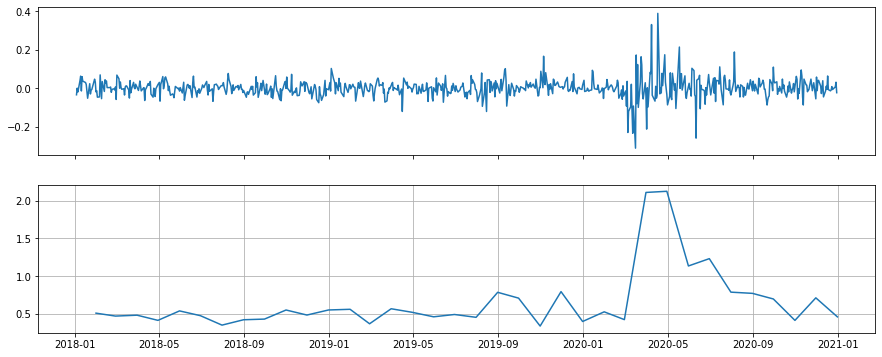

In [ ]:
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)
df_rv.rv = df_rv.rv * np.sqrt(12)
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (15,6))
ax[0].plot(df)
ax[1].plot(df_rv)

plt.grid(True)
plt.show()

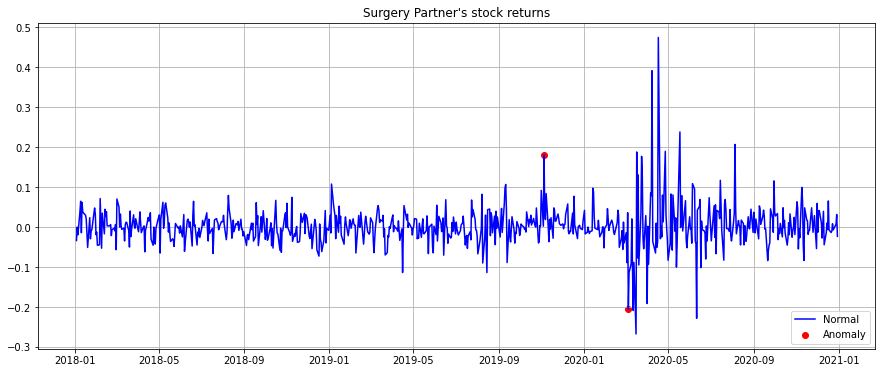

In [ ]:
df = db.quote()

df = df.loc[:, ['Adj Close']]
df = df.rename(columns={'Adj Close':'adj_close'})

df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
# print(df)

# Calculate the rolling mean and standard deviation:
df_rolling = df[['simple_rtn']].rolling(window=21) \
                               .agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

# Join the rolling metrics to the original data:
df_outliers = df.join(df_rolling)

# Define a function for detecting outliers:
def indentify_outliers(row, n_sigmas=3):
    '''
    Function for identifying the outliers using the 3 sigma rule. 
    The row must contain the following columns/indices: simple_rtn, mean, std.
    
    Parameters
    ----------
    row : pd.Series
        A row of a pd.DataFrame, over which the function can be applied.
    n_sigmas : int
        The number of standard deviations above/below the mean - used for detecting outliers
        
    Returns
    -------
    0/1 : int
        An integer with 1 indicating an outlier and 0 otherwise.
    '''
    x = row['simple_rtn']
    mu = row['mean']
    sigma = row['std']
    
    if (x > mu + n_sigmas * sigma) | (x < mu - n_sigmas * sigma):
        return 1
    else:
        return 0

# Identify the outliers and extract their values for later use:
df_outliers['outlier'] = df_outliers.apply(indentify_outliers, 
                                           axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1, 
                           ['simple_rtn']]

# plot
fig, ax = plt.subplots(figsize = (15,6))

ax.plot(df_outliers.index, df_outliers.simple_rtn, 
        color='blue', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, 
           color='red', label='Anomaly')
ax.set_title("Surgery Partner's stock returns")
ax.legend(loc='lower right')

plt.grid(True)
plt.show()

## Backtest

### BollingerBand

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
2020-03-16, BUY CREATED --- Size: 400, Cash: 10000.00, Open: 25.0, Close: 22.190000534057617
2020-03-16, Order Failed
2020-03-20, BUY CREATED --- Size: 405, Cash: 10000.00, Open: 24.649999618530273, Close: 25.100000381469727
2020-03-20, BUY EXECUTED --- Price: 24.65, Cost: 9983.25, Commission: 9.98
2020-05-15, SELL CREATED --- Size: 405
2020-05-15, SELL EXECUTED --- Price: 44.46, Cost: 9983.25,Commission: 18.01
2020-05-15, OPERATION RESULT --- Gross: 8023.05, Net: 7995.06
2020-06-09, BUY CREATED --- Size: 454, Cash: 17995.06, Open: 39.560001373291016, Close: 41.900001525878906
2020-06-09, BUY EXECUTED --- Price: 39.56, Cost: 17960.24, Commission: 17.96
2020-07-02, SELL CREATED --- Size: 454
2020-07-02, SELL EXECUTED --- Price: 50.00, Cost: 17960.24,Commission: 22.70
2020-07-02, OPERATION RESULT --- Gross: 4739.76, Net: 4699.10
2020-10-30, BUY CREATED --- Size: 333, Cash: 22694.16, Op

<IPython.core.display.Javascript object>

OrderedDict([('rtot', 0.963873827929258), ('ravg', 0.0038248961425764207), ('rnorm', 1.6218333577608113), ('rnorm100', 162.18333577608112)])


<IPython.core.display.Javascript object>

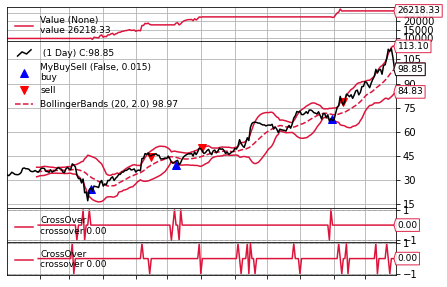

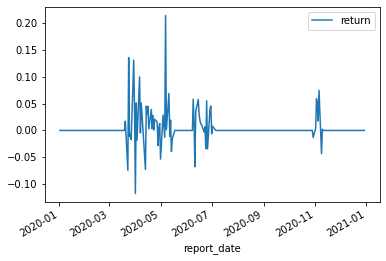

In [ ]:
import backtrader as bt

class MyBuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='^', markersize=8.0, color='blue', fillstyle='full'),
        sell=dict(marker='v', markersize=8.0, color='red', fillstyle='full')
    )


# create a Stratey
class BBand_Strategy(bt.Strategy):
    params = (('period', 20),
              ('devfactor', 2.0),)

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add Bollinger Bands indicator and track the buy/sell signals
        self.b_band = bt.ind.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.devfactor)
        self.buy_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.bot)
        self.sell_signal = bt.ind.CrossOver(self.datas[0], self.b_band.lines.top)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.buy_signal > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.sell_signal < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)


class TradeSizer(bt.Sizer):
  params = (('stake', 1),)    
  def _getsizing(self, comminfo, cash, data, isbuy):        
    if isbuy: return self.p.stake        
    
    position = self.broker.getposition(data)        
    if not position.size: return 0        
    else: return position.size   
     
    return self.p.stake 

ticker = "NTRA"
start_date = dt.datetime(2020,1,1)
end_date = dt.datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()
data = bt.feeds.PandasData(dataname=df)

# Create a cerebro entity
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

# set up the backtest
cerebro.addstrategy(BBand_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(MyBuySell)
cerebro.addsizer(TradeSizer)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')


print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot(iplot=True, volume=False)

# returns analyzer
print(backtest_result[0].analyzers.returns.get_analysis())

# returns over time analyzer
#%%
# plt.style.use('seaborn') #set style to `seaborn`
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
pd.DataFrame(list(returns_dict.items()), columns = ['report_date', 'return']).set_index('report_date').plot()

### RSI

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
Final Portfolio Value: 9992.39


<IPython.core.display.Javascript object>

OrderedDict([('rtot', -0.0007617303396508569), ('ravg', -3.022739443058956e-06), ('rnorm', -0.0007614402967451861), ('rnorm100', -0.07614402967451861)])


<IPython.core.display.Javascript object>

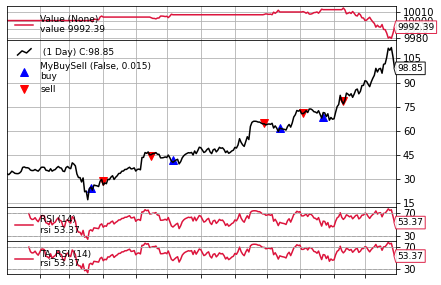

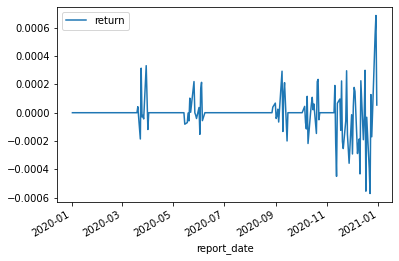

In [ ]:
class MyBuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='^', markersize=8.0, color='blue', fillstyle='full'),
        sell=dict(marker='v', markersize=8.0, color='red', fillstyle='full')
    )

# create a Stratey
class RsiSignalStrategy(bt.SignalStrategy):
    params = dict(rsi_periods=14, rsi_upper=70, rsi_lower=30, rsi_mid=50)

    def __init__(self):

        # add RSI indicator
        rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                upperband=self.p.rsi_upper,
                                lowerband=self.p.rsi_lower)

        # add RSI from TA-lib just for reference
        bt.ind.RSI(self.data, plotname='TA_RSI')

        # long condition (with exit)
        rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower, plot=False)
        self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
        self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi > self.p.rsi_mid))

        # short condition (with exit)
        rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper, plot=False)
        self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
        self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)


ticker = "NTRA"
start_date = dt.datetime(2020,1,1)
end_date = dt.datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()
data = bt.feeds.PandasData(dataname=df)



# create a Cerebro entity
cerebro = bt.Cerebro(stdstats = False)

# # set up the backtest
cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')


print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot(iplot=True, volume=False)

# returns analyzer
print(backtest_result[0].analyzers.returns.get_analysis())

# returns over time analyzer
#%%
# plt.style.use('seaborn') #set style to `seaborn`
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
pd.DataFrame(list(returns_dict.items()), columns = ['report_date', 'return']).set_index('report_date').plot()

## Simple Moving Average

In [ ]:
class MyBuySell(bt.observers.BuySell):
    plotlines = dict(
        buy=dict(marker='^', markersize=8.0, color='blue', fillstyle='full'),
        sell=dict(marker='v', markersize=8.0, color='red', fillstyle='full')
    )

class SmaStrategy(bt.Strategy):
    params = (('ma_period', 20), )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)
        
    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.data_close[0] > self.sma[0]:
                self.log(f'BUY CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.buy()
        else:
            # sell condition
            if self.data_close[0] < self.sma[0]:            
                self.log(f'SELL CREATED --- Price: {self.data_close[0]:.2f}')
                self.order = self.sell()


ticker = "NTRA"
start_date = dt.datetime(2020,1,1)
end_date = dt.datetime(2020,12,31)
class DataBase():
  def __init__(self, ticker, days):
    self.ticker = ticker
    data = yf.download(ticker, start = start_date, end =end_date )
    self.df = pd.DataFrame(data)
    pd.set_option("display.max_columns", None)
    self.df[self.df.index.dayofweek < 5]
    self.df= self.df[-days:]

  def quote(self):
    return self.df

db = DataBase(ticker, 1000)
df = db.quote()
data = bt.feeds.PandasData(dataname=df)

cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

[*********************100%***********************]  1 of 1 completed
Starting Portfolio Value: 10000.00
2020-01-30, BUY CREATED --- Price: 35.44
2020-01-31, BUY EXECUTED --- Price: 35.24, Cost: 35.24, Commission: 0.00
2020-01-31, SELL CREATED --- Price: 35.01
2020-02-03, SELL EXECUTED --- Price: 35.22, Cost: 35.24, Commission: 0.00
2020-02-03, OPERATION RESULT --- Gross: -0.02, Net: -0.02
2020-02-03, BUY CREATED --- Price: 36.11
2020-02-04, BUY EXECUTED --- Price: 36.72, Cost: 36.72, Commission: 0.00
2020-02-07, SELL CREATED --- Price: 35.56
2020-02-10, SELL EXECUTED --- Price: 35.41, Cost: 36.72, Commission: 0.00
2020-02-10, OPERATION RESULT --- Gross: -1.31, Net: -1.31
2020-02-12, BUY CREATED --- Price: 36.51
2020-02-13, BUY EXECUTED --- Price: 36.23, Cost: 36.23, Commission: 0.00
2020-02-13, SELL CREATED --- Price: 35.01
2020-02-14, SELL EXECUTED --- Price: 35.03, Cost: 36.23, Commission: 0.00
2020-02-14, OPERATION RESULT --- Gross: -1.20, Net: -1.20
2020-02-19, BUY CREATED --- Pric

## Interactive Dashboard for Technical Analysis

In [ ]:
!pip install chart_studio
import chart_studio.plotly as py
from chart_studio.plotly import iplot
import ipywidgets as wd
from ipywidgets import interact, interact_manual
import cufflinks as cf
import pandas as pd 
import yfinance as yf
# from plotly import __version__ 
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

In [ ]:
stocks = ["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
indicators = ['Bollinger Bands', 'MACD', 'RSI']

# function for creating the interactive plot:
def ta_dashboard(stocks, indicator, start_date, end_date, 
                 bb_k, bb_n, macd_fast, macd_slow, macd_signal,
                 rsi_periods, rsi_upper, rsi_lower):
    
    df = yf.download(stocks, 
                     start=start_date, 
                     end=end_date,
                     progress=False,
                     auto_adjust=True)

    qf = cf.QuantFig(df, title=f'TA Dashboard - {stocks}', 
                     legend='right', name=f'{stocks}')
            
    if 'Bollinger Bands' in indicator: 
        qf.add_bollinger_bands(periods=bb_n, 
                               boll_std=bb_k)
    if 'MACD' in indicator: 
        qf.add_macd(fast_period=macd_fast, 
                    slow_period=macd_slow, 
                    signal_period=macd_signal)
    if 'RSI' in indicator: 
        qf.add_rsi(periods=rsi_periods, 
                   rsi_upper=rsi_upper, 
                   rsi_lower=rsi_lower, 
                   showbands=True)

    return qf.iplot()


# Define the selectors:
stocks_selector = wd.Dropdown(
    options=stocks, 
    value=stocks[0], 
    description='Asset'
)

indicator_selector = wd.SelectMultiple(
    description='Indicator',
    options=indicators, 
    value=[indicators[0]]
)

start_date_selector = wd.DatePicker(
    description='Start Date', 
    value=pd.to_datetime('2020-01-01'), 
    continuous_update=False
)

end_date_selector = wd.DatePicker(
    description='End Date', 
    value=pd.to_datetime('2020-12-31'), 
    continuous_update=False
)

# Define a label and group the selectors inside a container:
main_selector_label = wd.Label('Main parameters', 
                               layout=wd.Layout(height='45px'))

main_selector_box = wd.VBox(children=[main_selector_label,
                                      stocks_selector,
                                      indicator_selector,
                                      start_date_selector,
                                      end_date_selector])

# Define the secondary selectors for Bollinger Bands:
bb_label = wd.Label('Bollinger Bands')

n_param = wd.IntSlider(value=20, min=1, max=40, step=1, 
                       description='N:', continuous_update=False)

k_param = wd.FloatSlider(value=2, min=0.5, max=4, step=0.5, 
                         description='k:', continuous_update=False)

bollinger_box = wd.VBox(children=[bb_label, n_param, k_param])

# Define the secondary selectors for MACD:
macd_label = wd.Label('MACD')

macd_fast = wd.IntSlider(value=12, min=2, max=50, step=1, 
                         description='Fast avg:', 
                         continuous_update=False)

macd_slow = wd.IntSlider(value=26, min=2, max=50, step=1, 
                         description='Slow avg:', 
                         continuous_update=False)

macd_signal = wd.IntSlider(value=9, min=2, max=50, step=1, 
                           description='MACD signal:', 
                           continuous_update=False)

macd_box = wd.VBox(children=[macd_label, macd_fast, 
                             macd_slow, macd_signal])

# Define the secondary selectors for RSI:
rsi_label = wd.Label('RSI')

rsi_periods = wd.IntSlider(value=14, min=2, max=50, step=1, 
                           description='RSI periods:', 
                           continuous_update=False)

rsi_upper = wd.IntSlider(value=70, min=1, max=100, step=1, 
                         description='Upper Thr:', 
                         continuous_update=False)

rsi_lower = wd.IntSlider(value=30, min=1, max=100, step=1, 
                         description='Lower Thr:', 
                         continuous_update=False)

rsi_box = wd.VBox(children=[rsi_label, rsi_periods, 
                            rsi_upper, rsi_lower])

# Create the labels and group the selectors into containers:
sec_selector_label = wd.Label('Secondary parameters', 
                              layout=wd.Layout(height='45px'))
blank_label = wd.Label('', layout=wd.Layout(height='45px'))

sec_box_1 = wd.VBox([sec_selector_label, bollinger_box, macd_box])
sec_box_2 = wd.VBox([blank_label, rsi_box])

secondary_selector_box = wd.HBox([sec_box_1, sec_box_2])

# Group the boxes and prepare the interactive output:
controls_dict = {'stocks':stocks_selector, 
                 'indicator':indicator_selector, 
                 'start_date':start_date_selector, 
                 'end_date':end_date_selector, 
                 'bb_k':k_param, 
                 'bb_n':n_param,
                 'macd_fast': macd_fast, 
                 'macd_slow': macd_slow, 
                 'macd_signal': macd_signal,
                 'rsi_periods': rsi_periods, 
                 'rsi_upper': rsi_upper,
                 'rsi_lower': rsi_lower}

ui = wd.HBox([main_selector_box, secondary_selector_box])
out = wd.interactive_output(ta_dashboard, controls_dict)

# Display the dashboard:
display(ui, out)


Output()